In [1]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

### First, let's prepare the data

In [2]:
# Loading data sets
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

In [3]:
print(f'There are {len(sss_batchA)} rows in the Batch A')

There are 5176 rows in the Batch A


Remove duplicated columns

In [4]:
# Look for duplicated columns
dup_cols = fun.getDuplicateColumns(sss_batchA)
print(f'The duplicate columns are:\n {dup_cols}')

The duplicate columns are:
 ['Location_Center_Y_nuclei', 'Location_Center_Y_cytoplasm', 'Location_Center_X_cytoplasm', 'AreaShape_BoundingBoxMaximum_Y_cytoplasm', 'AreaShape_BoundingBoxMinimum_X_cytoplasm', 'AreaShape_BoundingBoxArea_cytoplasm', 'Location_Center_X_nuclei', 'Intensity_MeanIntensity_illumMITO_cells.1', 'AreaShape_MinFeretDiameter_cytoplasm', 'Location_Center_Y_cells', 'AreaShape_MaxFeretDiameter_cytoplasm', 'AreaShape_BoundingBoxMaximum_X_cytoplasm', 'AreaShape_BoundingBoxMinimum_Y_cytoplasm', 'Location_Center_X_cells']


In [5]:
# I need to keep Intensity_MeanIntensity_illumMITO_cells.1 for later computations
iaux = dup_cols.index("Intensity_MeanIntensity_illumMITO_cells.1")
dup_cols[iaux]= 'Intensity_MeanIntensity_illumMITO_cells'

In [6]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(dup_cols, axis=1)

Removing not useful columns (according to Jonne)

In [7]:
filter_col = [col for col in sss_batchA.columns if 'MITO' in col]
print(f'There are {len(filter_col)} columns containig info about MITO')
print(filter_col[-1])

There are 364 columns containig info about MITO
Intensity_MeanIntensity_illumMITO_cells.1


In [8]:
filter_col = filter_col[:-1] # IF Intensity_MeanIntensity_illumMITO_cells.1 is in the last position

In [9]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(filter_col, axis=1)

In [10]:
print(f'Now the shape of Batch A is: {sss_batchA.shape}')

Now the shape of Batch A is: (5176, 1507)


In [11]:
compound_volume0 = ['CBK309099','CBK290175','CBK290175','CBK290175','CBK290175','CBK308178','CBK308178','CBK308178','CBK308178',
                    'CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309392',
                    'CBK309392','CBK290631','CBK309251','CBK309251','CBK309251','CBK309251','CBK290950','CBK290950','CBK290950','CBK290950']

# Removing compounds from cell profiler data frame
compound_volume0_idx = [sss_batchA.index[sss_batchA['ID_covid'] == comp].to_list() for comp in compound_volume0]
compound_volume0_idx = [item for sublist in compound_volume0_idx for item in sublist]
sss_batchA = sss_batchA.drop(compound_volume0_idx)

In [12]:
print(f'Now the shape of Batch A is: {sss_batchA.shape}')

Now the shape of Batch A is: (5167, 1507)


### Now we add the information for training + cleaning

First the cell profiler

In [13]:
#Remove columns that are "human-made", hence, not useful 
cell_profiler = sss_batchA.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)
cell_profiler = cell_profiler.rename(columns={'Intensity_MeanIntensity_illumMITO_cells.1': 'Target'})
cell_profiler.head()

<ipython-input-13-53595da63f66>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cell_profiler = sss_batchA.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)


,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,-0.041472,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,0.008777
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.012074,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,0.008477
2,199.000000,1752.473795,2362.270982,1103.365280,1137.814079,1055.657555,1089.743856,1079.003305,1113.304014,1.139450,...,0.052860,0.019217,-0.019048,0.025002,-0.032270,-0.019920,0.020209,0.031901,0.039423,0.008487
3,226.555556,1986.790362,2626.938955,1131.691573,1115.502430,1081.084579,1064.466968,1105.880512,1089.501774,1.125735,...,-0.003855,-0.066247,-0.009865,0.105897,0.050925,-0.084664,0.028926,-0.009254,0.000593,0.005784
4,197.222222,1727.657115,2330.338123,1086.800230,1144.507585,1039.318721,1096.989619,1062.571514,1120.267519,1.137588,...,0.017231,-0.008669,-0.019241,0.012336,0.048515,0.062975,-0.019302,0.009554,0.011530,0.008265


In [14]:
cell_profiler['cell_profiler_vector'] = cell_profiler.apply(lambda r: tuple(r[0:-1]), axis=1).apply(np.array)
cell_profiler = cell_profiler.reset_index(drop=True)
cell_profiler

,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target,cell_profiler_vector
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,0.008777,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,0.008477,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."
2,199.000000,1752.473795,2362.270982,1103.365280,1137.814079,1055.657555,1089.743856,1079.003305,1113.304014,1.139450,...,0.019217,-0.019048,0.025002,-0.032270,-0.019920,0.020209,0.031901,0.039423,0.008487,"[199.0, 1752.473795, 2362.270982, 1103.36528, ..."
3,226.555556,1986.790362,2626.938955,1131.691573,1115.502430,1081.084579,1064.466968,1105.880512,1089.501774,1.125735,...,-0.066247,-0.009865,0.105897,0.050925,-0.084664,0.028926,-0.009254,0.000593,0.005784,"[226.5555556, 1986.790362, 2626.938955, 1131.6..."
4,197.222222,1727.657115,2330.338123,1086.800230,1144.507585,1039.318721,1096.989619,1062.571514,1120.267519,1.137588,...,-0.008669,-0.019241,0.012336,0.048515,0.062975,-0.019302,0.009554,0.011530,0.008265,"[197.2222222, 1727.657115, 2330.338123, 1086.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,203.777778,1667.161061,2267.327924,1145.113236,1132.118069,1098.520189,1085.224386,1121.318458,1108.192044,1.150521,...,-0.025470,-0.138080,0.038031,-0.048695,0.029586,-0.011567,-0.031315,-0.000992,0.009815,"[203.7777778, 1667.161061, 2267.327924, 1145.1..."
5163,203.777778,1615.980907,2212.390640,1117.780128,1065.920552,1071.824189,1019.814822,1094.312557,1042.373580,1.154919,...,0.004824,-0.070471,0.042961,-0.043562,0.081066,-0.038034,-0.040628,0.102667,0.011134,"[203.7777778, 1615.980907, 2212.39064, 1117.78..."
5164,158.555556,1604.295761,2231.107003,1066.248247,1090.236381,1020.215905,1044.197701,1042.740254,1066.645620,1.169757,...,0.084618,0.067689,0.019191,-0.031676,-0.036528,0.027124,-0.138079,0.001796,0.010978,"[158.5555556, 1604.295761, 2231.107003, 1066.2..."
5165,172.555556,1598.984046,2182.850860,1092.243045,1146.370058,1046.769480,1100.123443,1068.988065,1122.763485,1.150945,...,-0.049963,0.036436,-0.011246,0.058061,-0.003082,-0.009142,0.006090,-0.046265,0.009783,"[172.5555556, 1598.984046, 2182.85086, 1092.24..."


In [184]:
#regression_data_batchA = r'/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/regression_data_batchA.csv'
#cell_profiler.to_csv(regression_data_batchA, sep=',', encoding='utf-8',index=False)

### Feature selection

So far I have filtered all the columns that contained something related to the MITO chanell. Now, according to the paper "A phenomic approach for antiviral drug discovery", there are features, specifically correlation, 
neighbours, concavalin and syto, that are more important. Hence, I am going to filter more to use only that information. 

In [15]:
# Selecting features according to the paper
group1 = [col for col in cell_profiler.columns if ('Granu' in col  and 'SYTO' in col) or ('Inten' in col and 'SYTO' in col) and not 'Location' in col and not 'Radial' in col]
group2 = [col for col in cell_profiler.columns if ('Granu' in col  and 'CONC' in col) or ('Inten' in col and 'CONC' in col) and not 'Location' in col and not 'Radial' in col]
group3 = [col for col in cell_profiler.columns if 'Correla' in col or 'Neig' in col]

filtered_features = group1+group2+group3

# Filtering
filtered_cell_profiler = cell_profiler[filtered_features+['Target','cell_profiler_vector']]

In [16]:
filtered_cell_profiler

,Granularity_10_illumSYTO_nuclei,Granularity_11_illumSYTO_nuclei,Granularity_12_illumSYTO_nuclei,Granularity_13_illumSYTO_nuclei,Granularity_14_illumSYTO_nuclei,Granularity_15_illumSYTO_nuclei,Granularity_16_illumSYTO_nuclei,Granularity_1_illumSYTO_nuclei,Granularity_2_illumSYTO_nuclei,Granularity_3_illumSYTO_nuclei,...,Correlation_RWC_illumHOECHST_illumPHAandWGA_cytoplasm,Correlation_RWC_illumHOECHST_illumSYTO_cytoplasm,Correlation_RWC_illumPHAandWGA_illumCONC_cytoplasm,Correlation_RWC_illumPHAandWGA_illumHOECHST_cytoplasm,Correlation_RWC_illumPHAandWGA_illumSYTO_cytoplasm,Correlation_RWC_illumSYTO_illumCONC_cytoplasm,Correlation_RWC_illumSYTO_illumHOECHST_cytoplasm,Correlation_RWC_illumSYTO_illumPHAandWGA_cytoplasm,Target,cell_profiler_vector
0,4.361841,3.584432,3.342588,2.438684,2.455154,1.976695,2.001378,9.488776,2.380306,3.854341,...,0.775435,0.756380,0.722137,0.591659,0.828587,0.809824,0.656284,0.913003,0.008777,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,3.959050,3.414357,2.863476,2.486072,2.171766,1.809120,1.267149,11.744559,2.641746,4.127440,...,0.768947,0.765124,0.704358,0.532513,0.819351,0.795736,0.601653,0.897047,0.008477,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."
2,4.349187,3.838771,3.244301,2.603814,2.302234,2.055301,1.868436,12.560360,2.116105,3.498266,...,0.752523,0.735974,0.704603,0.580412,0.803257,0.808617,0.651608,0.897853,0.008487,"[199.0, 1752.473795, 2362.270982, 1103.36528, ..."
3,3.992664,3.158369,2.529678,1.804955,1.437475,1.391254,1.186035,16.442088,2.074824,3.725266,...,0.731893,0.734542,0.743543,0.518442,0.797670,0.828538,0.578705,0.861295,0.005784,"[226.5555556, 1986.790362, 2626.938955, 1131.6..."
4,4.042045,3.297629,2.982852,2.552167,2.170422,1.917469,1.704661,11.297141,2.378388,3.986028,...,0.765918,0.757066,0.678658,0.540312,0.809617,0.783428,0.616865,0.900889,0.008265,"[197.2222222, 1727.657115, 2330.338123, 1086.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,4.586029,3.987638,3.237160,2.911563,2.687102,2.303301,1.853467,9.320676,2.862562,4.295627,...,0.765387,0.752188,0.726400,0.570664,0.830599,0.814182,0.637734,0.915446,0.009815,"[203.7777778, 1667.161061, 2267.327924, 1145.1..."
5163,4.703513,4.036346,3.828274,2.991866,2.378707,2.247013,1.926051,8.647649,2.924413,4.307183,...,0.768007,0.759339,0.744845,0.573191,0.843336,0.824301,0.638707,0.918787,0.011134,"[203.7777778, 1615.980907, 2212.39064, 1117.78..."
5164,5.035118,4.401190,3.585528,2.949741,2.646095,2.207923,2.020640,8.502608,3.045520,4.290687,...,0.763024,0.759621,0.756895,0.564578,0.856821,0.826230,0.622314,0.921777,0.010978,"[158.5555556, 1604.295761, 2231.107003, 1066.2..."
5165,4.381050,3.690412,3.451646,2.912654,2.418330,2.176244,1.666272,8.621927,3.232583,4.465332,...,0.771411,0.758128,0.735672,0.574595,0.845911,0.815877,0.637306,0.922736,0.009783,"[172.5555556, 1598.984046, 2182.85086, 1092.24..."


### Now training

1. Creating training and tests sets

In [21]:
# We get the input values
X =  cell_profiler.iloc[:,:-2]
# Output values
y = 1000*cell_profiler.iloc[:,-2]

# Re-scale
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500
0,-0.107728,1.239198,1.167609,-0.482631,1.140747,-0.518719,1.099841,-0.501259,1.120302,-0.884358,...,-0.755966,-1.026410,1.000601,-1.426433,0.245300,0.762549,2.842807,-0.245682,2.989801,0.860631
1,2.013660,0.305987,-0.086490,0.188351,1.412834,0.188224,1.401132,0.188508,1.407069,-1.351787,...,-1.407816,-0.417903,-0.119504,2.041143,-0.605380,0.116426,0.621445,0.585670,-0.402089,-0.130295
2,0.143240,0.620574,0.506386,-0.192122,0.695846,-0.207581,0.671964,-0.199984,0.684649,-0.767405,...,-0.864495,0.926178,0.781536,-0.385767,0.450136,-0.639883,-0.441966,0.439557,0.697913,0.797335
3,1.317579,3.654337,3.255991,0.672248,0.016592,0.568471,-0.096899,0.620369,-0.039750,-2.156958,...,-3.945358,-0.247766,-1.004849,-0.194872,2.165622,1.118229,-1.807797,0.624545,-0.189090,-0.031203
4,0.067476,0.299265,0.174639,-0.697601,0.899622,-0.706254,0.892362,-0.701520,0.896577,-0.956002,...,-0.416337,0.188694,0.198654,-0.389778,0.181537,1.067298,1.306801,-0.398901,0.216276,0.202172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,0.346855,-0.483994,-0.479967,1.081808,0.522437,1.100619,0.534492,1.091570,0.529071,0.354302,...,0.245601,-0.474582,-0.152525,-2.860311,0.726424,-0.986981,0.602433,-0.234770,-0.664562,-0.065029
5163,0.346855,-1.146638,-1.050704,0.247744,-1.492874,0.285837,-1.455111,0.267289,-1.474053,0.799845,...,0.810322,0.305472,0.480695,-1.454795,0.830986,-0.878519,1.688469,-0.796419,-0.865290,2.146827
5164,-1.580388,-1.297929,-0.856262,-1.324741,-0.752605,-1.289287,-0.713442,-1.306814,-0.735356,2.303194,...,1.354873,-0.553068,2.148547,1.417388,0.326906,-0.627323,-0.792318,0.586307,-2.965615,-0.005542
5165,-0.983747,-1.366701,-1.357590,-0.531515,0.956323,-0.478852,0.987686,-0.505672,0.972539,0.397202,...,0.856758,1.441532,-0.664472,0.767670,-0.318569,1.269042,-0.086749,-0.183306,0.141610,-1.031048


In [22]:
# We get the input values
X_filtered =  filtered_cell_profiler.iloc[:,:-2]

# Re-scale
scaler = StandardScaler()
X_filtered = pd.DataFrame(scaler.fit_transform(X_filtered))
X_filtered

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,-0.257914,-0.503403,0.368115,-1.095521,0.177077,-0.430929,0.795305,-0.046790,-1.321457,-0.836086,...,0.170116,0.076296,0.748799,0.169360,-0.087611,0.648681,-0.203668,-0.033160,0.743814,0.100900
1,-1.351104,-0.978272,-1.053952,-0.941708,-0.821612,-1.089779,-2.370635,1.530151,-0.441446,0.073379,...,-0.776891,0.733642,0.276178,0.731734,-0.770309,-1.259507,-0.719190,-0.907220,-1.347615,-1.314692
2,-0.292257,0.206746,0.076387,-0.559541,-0.361829,-0.121880,0.222068,2.100450,-2.210764,-2.021869,...,-0.614305,-0.786486,-0.920356,-1.143140,-0.760895,0.285831,-1.617476,-0.108020,0.564839,-1.243213
3,-1.259874,-1.693025,-2.044711,-3.152486,-3.409335,-2.732680,-2.720392,4.814035,-2.349717,-1.265924,...,-0.800588,3.368160,-2.423337,-1.235297,0.734348,-1.713448,-1.929259,1.127889,-2.226118,-4.486775
4,-1.125852,-1.304193,-0.699630,-0.727178,-0.826347,-0.663788,-0.484115,1.217376,-1.327913,-0.397548,...,-1.279884,-0.715382,0.055487,0.213475,-1.757143,-1.007877,-1.262469,-1.670823,-0.765251,-0.973857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,0.350542,0.622401,0.055192,0.439353,0.994491,0.853169,0.157524,-0.164303,0.301825,0.633466,...,0.196056,0.113013,0.016828,-0.100313,0.076090,-0.028682,-0.091369,0.237186,0.033689,0.317694
5163,0.669399,0.758400,1.809696,0.700002,-0.092329,0.631864,0.470503,-0.634794,0.510016,0.671948,...,0.126944,0.582826,0.207708,0.359684,0.784367,0.052846,0.619493,0.865013,0.070952,0.614092
5164,1.569386,1.777094,1.089193,0.563271,0.849976,0.478177,0.878359,-0.736187,0.917663,0.617015,...,1.293937,0.712350,-0.155374,0.377773,1.247087,-0.225002,1.372138,0.984667,-0.556620,0.879421
5165,-0.205780,-0.207491,0.691815,0.442894,0.047307,0.353626,-0.649646,-0.652776,1.547321,1.198609,...,0.470867,0.184642,0.455690,0.281784,0.432123,0.098151,0.763248,0.342401,0.017309,0.964534


2) K-fold cross validationd and linear regression

In [24]:
y_frame = pd.DataFrame({'MITO': y.values.flatten()})
y_frame = fun.labelling_v2(y_frame, col_reference=0, labels_position = 1, label_positive=1, label_negative=0, threshold=7.5)
y_frame = y_frame.groupby('Labels_0').count()
print(f'Percentage of positives in the total dataframe with {7.5} as threshold: {y_frame.MITO[1]*100 / y_frame.MITO.sum()}%')

Percentage of positives in the total dataframe with 7.5 as threshold: 2.5933810721888912%


In [25]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = LinearRegression()
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
     
    acc = mean_squared_log_error(y_pred , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.004070839528031904, 0.003762665263325957, 0.004668371420549507, 0.003774423715003656, 0.003163123509670606]
Avg accuracy : 0.0038878846873163257


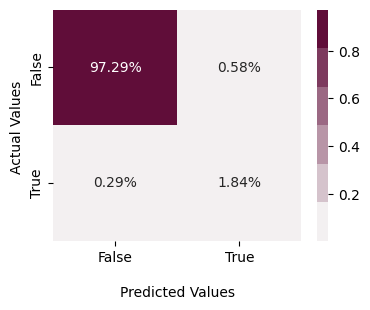

In [19]:
# Plot results
results = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})
results = fun.labelling_v2(results, col_reference='Actual', labels_position = 1, label_positive=1, label_negative=0, threshold=thr)
results = fun.labelling_v2(results, col_reference='Predicted', labels_position = 3, label_positive=1, label_negative=0, threshold=thr)

cd_mo = confusion_matrix(results['Labels_Actual'].tolist(), results['Labels_Predicted'].tolist())
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = sns.heatmap(cd_mo/np.sum(cd_mo), annot=True, fmt = '.2%', cmap=sns.light_palette((.376, .051, .224)), ax=ax)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

I) DEFAULT MODELS 

In [107]:
#Parameters
thr = 7.5
cv_k = 5

In [108]:
#define cross-validation method to use
cv = KFold(n_splits=cv_k, random_state=1, shuffle=True)

#build multiple linear regression model
model1 = LinearRegression()
model2 = Lasso()
model3 = Ridge()
model4 = svm.SVR()
#model5 = DecisionTreeRegressor()
#model6 = AdaBoostRegressor()
#model7 =BaggingRegressor()
#model8 = RandomForestRegressor()
MODELS = [model1, model2, model3, model4]

MEAN_MODEL_SCORE = []
MEAN_MODEL_SCORE_dic = {}
for model in MODELS:
    
    print(f'Model: {model}')
    acc_score = []
    
    for train_index , test_index in cv.split(X):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        acc = mean_squared_error(y_pred , y_test)
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/k
    print('Avg meand squared error: {}'.format(avg_acc_score))
    #MEAN_MODEL_SCORE.append(avg_acc_score)
    MEAN_MODEL_SCORE_dic[str(model)] = acc_score

Model: LinearRegression()
Avg meand squared error: 0.4320917638547259
Model: Lasso()


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.665e+01, tolerance: 4.988e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.013e+01, tolerance: 4.927e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.285e+01, tolerance: 4.969e-01

Avg meand squared error: 0.5099212161520439
Model: Ridge()
Avg meand squared error: 0.3365285318444188
Model: SVR()
Avg meand squared error: 0.6684608062488768


b) Ensenmble models

In [109]:
model5 = DecisionTreeRegressor()
model6 = AdaBoostRegressor()
model7 = BaggingRegressor()
model8 = RandomForestRegressor()
MODELS = [model5, model6, model7, model8]

MEAN_MODEL_SCORE_dic_part2 = {}
for model in MODELS:
    
    print(f'Model: {model}')
    acc_score = []
    
    for train_index , test_index in cv.split(X):
        X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        acc = mean_squared_error(y_pred , y_test)
        acc_score.append(acc)

    avg_acc_score = sum(acc_score)/k
    print('Avg mean_squared_log_error : {}'.format(avg_acc_score))
    MEAN_MODEL_SCORE_dic_part2[str(model)] = acc_score

Model: DecisionTreeRegressor()
Avg mean_squared_log_error : 0.8399916137987008
Model: AdaBoostRegressor()
Avg mean_squared_log_error : 0.4791261331016621
Model: BaggingRegressor()
Avg mean_squared_log_error : 0.4591642543609913
Model: RandomForestRegressor()
Avg mean_squared_log_error : 0.40620045160462387


In [119]:
exp1 = list(MEAN_MODEL_SCORE_dic.values())+list(MEAN_MODEL_SCORE_dic_part2.values())

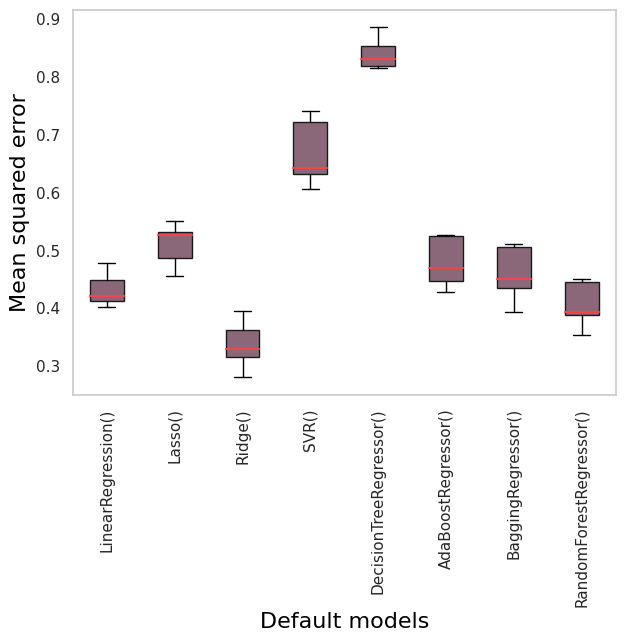

In [188]:
medianprops = dict(linestyle='-', linewidth=1.5, color=(.937, .275, .282))
models_name = ['LinearRegression()','Lasso()','Ridge()','SVR()']+[str(model) for model in MODELS]
fig, ax = plt.subplots(1, 1, figsize=(7,5))
bp = ax.boxplot(exp1,labels=models_name,patch_artist=True, medianprops=medianprops)
#Changing colour
for patch, color in zip(bp['boxes'], [(.345, .157, .255, 0.7)]*8):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k')
    
ax.set_ylabel('Mean squared error', color="black", fontsize=16)   
ax.set_xlabel('Default models', color="black", fontsize=16)
ax.grid(False)
plt.xticks(rotation=90)
#plt.savefig('repeated_compounds.jpg',bbox_inches='tight', dpi=150)
plt.show()

II) RIDGE REGRESSION